# Visualising FITS and star positions

In [1]:
import requests, math, glob
import pandas as pd
import numpy as np
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from photutils import aperture_photometry, CircularAperture
#from astroquery.simbad import Simbad
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn')
pd.options.mode.chained_assignment = None


In [2]:
import os
os.chdir('..')
import init
import do_calibration

In [12]:
def getWcs(wcs_file):
    hdulist = fits.open(wcs_file)
    data = hdulist[0].data.astype(float)
    header = hdulist[0].header
    wcs = WCS(header)
    return wcs

FITS_FILE=init.fitsdir+init.reference_frame
wcs_file = init.basedir+"new-image.fits"

wcs = getWcs(wcs_file)
vsx = do_calibration.getVSX(init.basedir+'SearchResults.csv')
candidates = do_calibration.getCandidates(0.7)
names = do_calibration.findNames()

#x_pix, y_pix = wcs.all_world2pix(ra_deg, dec_deg)
# x_world, y_world = gc.pixel2world(np.array([700]), np.array([700]))
print(names)

Got 31 candidates and 94 stars to check against.
{138: ['RRL_ab', 0.99, 0, <SkyCoord (ICRS): (ra, dec) in deg
    (271.40328856, -43.83223887)>, 'WW CrA', <SkyCoord (ICRS): (ra, dec) in deg
    (271.40329167, -43.83261111)>, 'RRAB/BL', 0.0003722439468105054, '0d00m01.3401s'], 886: ['RRL_ab', 0.99, 0, <SkyCoord (ICRS): (ra, dec) in deg
    (270.976716, -43.61397645)>, 'V0396 CrA', <SkyCoord (ICRS): (ra, dec) in deg
    (270.975125, -43.61436111)>, 'RRAB', 0.0012144170145626002, '0d00m04.3719s'], 287: ['EB_ED', 0.93, 0, <SkyCoord (ICRS): (ra, dec) in deg
    (271.31010637, -43.47294634)>, 'IY CrA', <SkyCoord (ICRS): (ra, dec) in deg
    (271.34729167, -43.56552778)>, 'M', 0.09642828759380664, '0d05m47.1418s'], 686: ['EB_ED', 0.92, 0, <SkyCoord (ICRS): (ra, dec) in deg
    (271.00579581, -43.48795059)>, 'V0396 CrA', <SkyCoord (ICRS): (ra, dec) in deg
    (270.975125, -43.61436111)>, 'RRAB', 0.12835009485295326, '0d07m42.0603s'], 895: ['EB_ED', 0.92, 0, <SkyCoord (ICRS): (ra, dec) in deg
 

In [33]:
# auid	dec	error	peak	ra	vmag	x	y

results = []
found_results = []

for variable in vsx:
    results.append({'auid': variable[0], 'coord': variable[1]})

for candidate in candidates:
    found_results.append({'auid': str(candidate[0]), 'coord': candidate[4]})

def add_pixels(results, offset):
    for star in results:
        star_coord = star['coord']
        xy = SkyCoord.to_pixel(star_coord, wcs=wcs, origin=1)
        x = xy[0].item(0)
        y = xy[1].item(0)
        star['x'] = x + offset
        star['y'] = y + offset
    results = pd.DataFrame(results)
    return results
results = add_pixels(results, 1000)
found_results = add_pixels(found_results, 1000)
print(len(found_results))
print(found_results)

11
   auid                                              coord            x  \
0   138  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.4...  1963.271425   
1   886  <SkyCoord (ICRS): (ra, dec) in deg\n    (270.9...  1446.811410   
2   287  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.3...  1881.201509   
3   686  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.0...  1494.531450   
4   895  <SkyCoord (ICRS): (ra, dec) in deg\n    (270.9...  1458.191448   
5   454  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.3...  1981.151525   
6   136  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.0...  1603.631466   
7   133  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.4...  1999.591526   
8   708  <SkyCoord (ICRS): (ra, dec) in deg\n    (270.9...  1385.821421   
9   348  <SkyCoord (ICRS): (ra, dec) in deg\n    (270.6...  1006.601273   
10  178  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.6...  2285.491570   

              y  
0   1712.249138  
1   2119.699146  
2   2344.429195  
3   2337.159170  
4   23

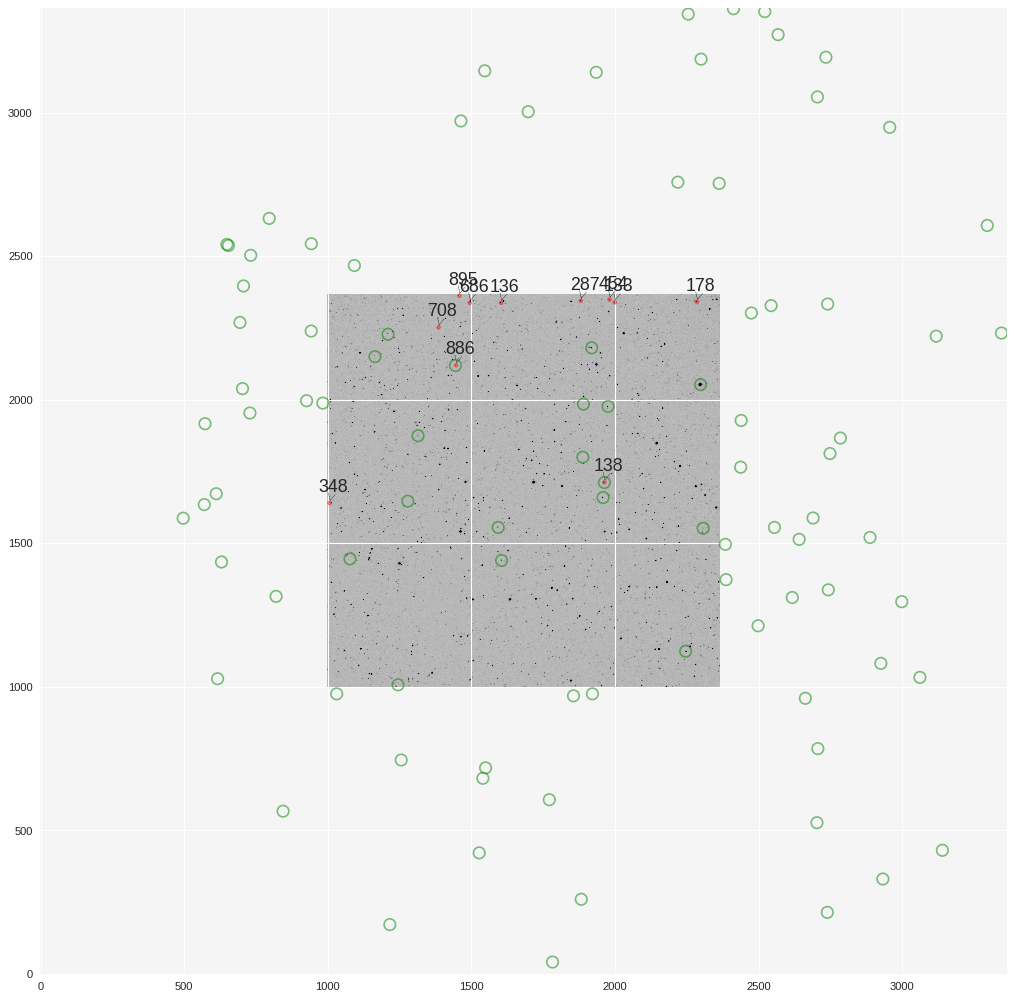

In [37]:
hdulist = fits.open(FITS_FILE)
data = hdulist[0].data.astype(float)
data = np.pad(data, (1000,1000), 'constant', constant_values=(100, 100))
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
known_positions = (results['x'], results['y'])    
found_positions = (found_results['x'], found_results['y'])
known_apps = CircularAperture(known_positions, r=20.)    
found_apps = CircularAperture(found_positions, r=5.)    
# target_app = CircularAperture(target_xy, r=20.)    
plt.imshow(data, cmap='gray_r', origin='lower', vmin=0, vmax=2500)
known_apps.plot(color='green', lw=1.5, alpha=0.5)
found_apps.plot(color='red', lw=1.5, alpha=0.5)
# target_app.plot(color='blue', lw=1.5, alpha=0.5)
#to_plot = results
def annotate_it(results, offset1, offset2, size=16):
    for to_annotate in results.iterrows():
        plt.annotate('{}'.format(to_annotate[1]['auid']),
            xy=(to_annotate[1]['x'], to_annotate[1]['y']), xycoords='data',
            xytext=(offset1, offset2), textcoords='offset points', size=size,
            arrowprops=dict(arrowstyle="->"))
#annotate_it(results, -150, 130, size=10)    
annotate_it(found_results, -10, 10)    


In [36]:
fig.savefig(init.basedir+'results')

In [28]:
data[1000]

array([585., 585., 585., ..., 585., 585., 585.])